# Symantic Classification of Urban Settlements
## Mort Canty
## June, 2021

## Context
 
[Fully convolutional neural networks](https://ieeexplore.ieee.org/document/7478072) (FCNs) are useful for object recognition and semantic image classification. In this tutorial we examine a popular FCN architecture, called [UNet](https://arxiv.org/abs/1505.04597), for urban building recognition (houses, commercial edifices, etc.) in aerial or satellite imagery. [Here](https://arxiv.org/abs/2107.12283) for example is a very recent application of the UNet architecture for large scale semantic classification of building footprints over the entire African continent.  

We will make use of the dataset  for the [INRIA Aerial Imaging Labeling Benchmark](https://hal.inria.fr/hal-01468452/document) published in 2016. The dataset, consisting of images and semantic labels, can be downloaded [here](https://project.inria.fr/aerialimagelabeling/), and a presentation of the most successful sematic classifiers determined in the benchmark competition is given [here](https://hal.inria.fr/hal-01767807/document). 


 
After programming and training a UNet network at a fourfold reduced spatial resolution to that used in the competition, we'll try to apply it images outside the INRIA training/test domain by classifying remote sensing images taken from the Google Earth Engine archive.

## Preliminaries

In [ ]:
import ee

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=BuAN-kz03JiR8rn8ExM4IlNTyA_K4a_eXJLIRwHXTU8&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWislQ9w0Fy3rgfjMKp9yO9IzR4Yp8GSMsPsDvqGfKGbDvEPP5ZWXSU

Successfully saved authorization token.


In [ ]:
# Initialize the library.
ee.Initialize()

In [1]:
import numpy as np
import scipy
from PIL import Image
import os, sys
from osgeo import gdal,gdalconst
from osgeo.gdalconst import GA_ReadOnly
from matplotlib import pyplot as plt
import matplotlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import *
%matplotlib inline

In [ ]:
# Import the Folium library.
import folium
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [2]:
# Colab only
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


## The training Dataset

To quote from the INRIA download site:

 _[the images] cover dissimilar urban settlements, ranging from densely populated areas (e.g., San Francisco’s financial district) to alpine towns (e.g,. Lienz in Austrian Tyrol)-_

There are 180 image/label pairs in all. Here is is an example of a full $5000\times 5000$-pixel image/label pair over Austin, Texas after upload to GEE and projection onto a folium map. For comparison and for later use we also display the corresponding spatial subset of the GEE's [USDA NAIP dataset](https://developers.google.com/earth-engine/datasets/catalog/USDA_NAIP_DOQQ). Note the poorer spatial resolution of the NAIP image (circa 1m) relative to the INRIA image (30cm).

In [ ]:
img = ee.Image('users/mortcanty/chicago3')
label = ee.Image('users/mortcanty/chicago_label3')
img_rgb = ee.Image.rgb(img.select(0),img.select(1),img.select(2))

location = img.geometry().centroid().coordinates().getInfo()[::-1]
m = folium.Map(location=location, zoom_start=15, height=800, width=1000)

m.add_ee_layer(img_rgb, {'min': 0, 'max': 200}, 'INRIA Train Image')
m.add_ee_layer(label, {'min': 0, 'max': 200}, 'INRIA Label Image')

naip = ee.ImageCollection('USDA/NAIP/DOQQ') \
                      .select(['R','G','B']) \
                      .filter(ee.Filter.date('2017-01-01', '2018-12-31')) \
                      .filterBounds(img.geometry()) \
                      .mosaic() \
                      .clip(img.geometry()) 

naip_rgb = ee.Image.rgb(naip.select(0),naip.select(1),naip.select(2))
m.add_ee_layer(naip, {'min': 0, 'max': 255}, 'NAIP Image')

m.add_child(folium.LayerControl())

display(m)

**Note:** The following cells should be run on the user's local machine, especially if disk space is a problem on Google Drive. The INRIA training data occupy 14 GB before compression but only about 1 GB when compressed. We'll assume that the train images are in the directory __train_folder/images__ and the labels in the diretory __train_folder/gt__.

In [2]:
# local only (insert your path here)
train_folder = '/media/mort/Crucial/imagery/Inria/AerialImageDataset/train'

### Numpy arrays for training and testing

The following function (somewhat wastefully) clips the original 180 5000$\times$ 5000 pixel Inria images and labels to 4096$\times$ 4096 and then compresses the result to 1024$\times$ 1024, thus generating training and test image sets with approx 1.2m ground resolution. Each image (and its label) is then split into four 512$\times$ 512 segments. 

After uploading the USA label images (just 72 scenes over Austin and Chicago, the others are European) to GEE, the corresponding NAIP images are clipped to the same dimensions and then downloaded at a scale of 1m. 

In [ ]:
start = 1
end = 36

#images = ['projects/ee-mortcanty/assets/inria/austin'+str(i) for i in range(start,end+1)]
#crs = 'EPSG:26914'
#fnp = 'austin'

images = ['projects/ee-mortcanty/assets/inria/chicago'+str(i) for i in range(start,end+1)]
crs = 'EPSG:26916'
fnp = 'chicago'

for i in range(start-1,end):
    filenameprefix = fnp+str(i+1)
    lbl = ee.Image(images[i])
    naip = ee.ImageCollection('USDA/NAIP/DOQQ') \
                      .select(['R','G','B']) \
                      .filter(ee.Filter.date('2017-01-01', '2018-12-31')) \
                      .filterBounds(lbl.geometry()) \
                      .mosaic() \
                      .clip(lbl.geometry()) 
    gdexport = ee.batch.Export.image.toDrive(naip,
                description='driveExportTask', 
                folder = 'naip_images',
                crs = crs,                             
                fileNamePrefix=filenameprefix,scale=1,maxPixels=1e11)   
    gdexport.start()
    gdexport1 = ee.batch.Export.image.toDrive(lbl,
                description='driveExportTask', 
                folder = 'naip_labels',
                fileNamePrefix=filenameprefix,scale=1,maxPixels=1e11)   
    gdexport1.start()    


These images and their labels are again split into four 512$\times$ 512 segments and appended to the Inria images. There are 4$\times$180 $+$ 4$\times$72 $=$ 1008 image/label pairs in all, whereby the Ausin and Chicago pairs are both Inria and NAIP acquisitions at slightly different resolutions. The images are then augmented by applying a histogram equalization stretch. This is a so-called *regularization* measure which, it is hoped, will improve generalization. This results in 2016 images altogether, of which 400 are split off for testing and validation.

In [3]:
def bytestretch(arr,rng=None):
#   byte stretch image numpy array
    shp = arr.shape
    arr = arr.ravel()
    if rng is None:
        rng = [np.min(arr),np.max(arr)]
    tmp =  (arr-rng[0])*255.0/(rng[1]-rng[0])
    tmp = np.where(tmp<0,0,tmp)  
    tmp = np.where(tmp>255,255,tmp) 
    return np.asarray(np.reshape(tmp,shp),np.uint8)

def histeqstr(x):
#   histogram equalization stretch        
    x = bytestretch(x)
    hist,bin_edges = np.histogram(x,256,(0,256))
    cdf = hist.cumsum()
    lut = 255*cdf/float(cdf[-1])
    return np.interp(x,bin_edges[:-1],lut)

def lin2pcstr(x):
#  2% linear stretch
    x = bytestretch(x)
    hist,bin_edges = np.histogram(x,256,(0,256))
    cdf = hist.cumsum()
    lower = 0
    i = 0
    while cdf[i] < 0.02*cdf[-1]:
        lower += 1
        i += 1
    upper = 255
    i = 255
    while (cdf[i] > 0.98*cdf[-1]) and (upper>100):
        upper -= 1
        i -= 1
    fp = (bin_edges-lower)*255/(upper-lower)
    fp = np.where(bin_edges<=lower,0,fp)
    fp = np.where(bin_edges>=upper,255,fp)
    return np.interp(x,bin_edges,fp)          

def make_traintest_arrays(folder,tmp='tmp.jpg'):

    gdal.AllRegister()
    translate_options = gdal.TranslateOptions(format='JPEG',outputType=gdalconst.GDT_Byte,
                                              resampleAlg='bilinear',
                                              width=1024,height=1024,srcWin=[0,0,4096,4096])
#  images
    files_inria = os.listdir(folder+'/images')
    files_inria.sort()
    files_naip = os.listdir(folder+'/naip_images')
    files_naip.sort()
    num_files = 8*len(files_inria)+4*len(files_naip)
    print('Number of files %i'%num_files)
    idx = np.random.permutation(range(num_files)) 
    images = np.zeros((num_files,512,512,3),dtype=np.uint8)
    i = 0
    print('images array:')
    for file in files_inria:
        if i%10 == 0:
            print( '%i '%i,end=' ') 
        gdal.Translate(tmp,folder+'/images/'+file,options=translate_options)
        img = np.reshape(np.asarray(Image.open(tmp)),(1024,1024,3))
        images[i,:,:,:] =   img[:512,:512,:]
        images[i+1,:,:,:] = img[:512,512:,:]
        images[i+2,:,:,:] = img[512:,:512,:]
        images[i+3,:,:,:] = img[512:,512:,:]                
#      augmentation histogram equalization stretch        
        imgheq = img*0
        for k in range(3):
            imgheq[:,:,k] = histeqstr(img[:,:,k])
        images[i+4,:,:,:] = imgheq[:512,:512,:]
        images[i+5,:,:,:] = imgheq[:512,512:,:]
        images[i+6,:,:,:] = imgheq[512:,:512,:]
        images[i+7,:,:,:] = imgheq[512:,512:,:]     
        i += 8
    for file in files_naip:
        if i%10 == 0:
            print( '%i '%i,end=' ') 
        inDataset = gdal.Open(folder+'/naip_images/'+file, GA_ReadOnly)
        img = np.zeros((1024,1024,3),dtype=np.uint8)                               
        for b in range(3):
            band = inDataset.GetRasterBand(b+1)
            img[:,:,b] = band.ReadAsArray(0,0,1024,1024)        
        images[i,:,:,:] =   img[:512,:512,:]
        images[i+1,:,:,:] = img[:512,512:,:]
        images[i+2,:,:,:] = img[512:,:512,:]
        images[i+3,:,:,:] = img[512:,512:,:]          
        i += 4         
#  shuffle        
    images = images[idx,:,:,:]    
#  labels    
    labels_inria = os.listdir(folder+'/gt')
    labels_inria.sort()
    labels_naip = os.listdir(folder+'/naip_labels')
    labels_naip.sort()
    labels = np.zeros((num_files,512,512,1),dtype=np.float32)
    i = 0
    print('\nlabels array:')
    for file in labels_inria:
        if i%10 == 0:
            print( '%i '%i,end=' ') 
        gdal.Translate(tmp,folder+'/gt/'+file,options=translate_options)
        img = np.reshape(np.asarray(Image.open(tmp)),(1024,1024,1))
        img = np.where(img>200,1,0)
        labels[i,:,:,:] =   img[:512,:512,:]
        labels[i+1,:,:,:] = img[:512,512:,:]
        labels[i+2,:,:,:] = img[512:,:512,:]
        labels[i+3,:,:,:] = img[512:,512:,:]
#      augmentation        
        labels[i+4,:,:,:] = img[:512,:512,:]
        labels[i+5,:,:,:] = img[:512,512:,:]
        labels[i+6,:,:,:] = img[512:,:512,:]
        labels[i+7,:,:,:] = img[512:,512:,:]        
        i += 8    
    for file in labels_naip:
        if i%10 == 0:
            print( '%i '%i,end=' ')       
        inDataset = gdal.Open(folder+'/naip_labels/'+file, GA_ReadOnly)                              
        band = inDataset.GetRasterBand(1)
        img = np.reshape(band.ReadAsArray(0,0,1024,1024),(1024,1024,1))  
        img = np.where(img>200,1,0)
        labels[i,:,:,:] =   img[:512,:512,:]
        labels[i+1,:,:,:] = img[:512,512:,:]
        labels[i+2,:,:,:] = img[512:,:512,:]
        labels[i+3,:,:,:] = img[512:,512:,:]          
        i += 4            
#  shuffle        
    labels = labels[idx,:,:,:]   
#  split off test data (400 image/label pairs)   
    split = num_files - 400
    x_train = images[:split,:,:,:]
    y_train = labels[:split,:,:,:]
    x_test = images[split:,:,:,:]
    y_test = labels[split:,:,:,:]
#  save compressed    
    np.savez_compressed(folder+'/images_trainxx.npz',x_train=x_train,y_train=y_train)
    np.savez_compressed(folder+'/images_testxx.npz',x_test=x_test,y_test=y_test)

In [4]:
# local only
make_traintest_arrays(train_folder)

Number of files 1728
images array:
0  40  80  120  160  200  240  280  320  360  400  440  480  520  560  600  640  680  720  760  800  840  880  920  960  1000  1040  1080  1120  1160  1200  1240  1280  1320  1360  1400  1440  1460  1480  1500  1520  1540  1560  1580  1600  1620  1640  1660  1680  1700  1720  
labels array:
0  40  80  120  160  200  240  280  320  360  400  440  480  520  560  600  640  680  720  760  800  840  880  920  960  1000  1040  1080  1120  1160  1200  1240  1280  1320  1360  1400  1440  1460  1480  1500  1520  1540  1560  1580  1600  1620  1640  1660  1680  1700  1720  

**Note:** The compressed .npz files should now be uploaded  to the folder **Inria** on the user's Google Drive. What follows is run in Colab with a GPU runtime.

In [3]:
# Colab only
train_folder = '/content/drive/MyDrive/Inria'

In [ ]:
!ls -l $train_folder

total 3683592
-rw------- 1 root root   38938949 Jun  6 19:13 images_test.npz
-rw------- 1 root root  706173163 Aug 12 11:48 images_testx.npz
-rw------- 1 root root  259688245 Aug 25 08:00 images_testxx.npz
-rw------- 1 root root  427064904 Jun  6 19:13 images_train.npz
-rw------- 1 root root 1115688632 Aug 12 11:47 images_trainx.npz
-rw------- 1 root root  394773890 Aug 25 08:00 images_trainxx.npz
-rw------- 1 root root  414833432 Aug 15 19:59 unet_inria_modelx.h5
-rw------- 1 root root  414834816 Aug 23 20:02 unet_inria_modelxx.h5


### Make train and test datasets in RAM
 
Since there are only 2880 image/label pairs in all (the images are $512\times 512\times 3$ RGB cubes in unsigned byte format, the labels are $512\times 512\times 1$ in 32 bit float), they can be conveniently kept in RAM during training. Both the training and test data are batched (batch size 4):

In [5]:
path = train_folder+'/images_trainxx.npz'
with np.load(path) as data:
  train_examples = data['x_train']
  train_labels = data['y_train']   
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels)).batch(4)

path = train_folder+'/images_testxx.npz'
with np.load(path) as data:
  test_examples = data['x_test']
  test_labels = data['y_test']        
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels)).batch(4) 

Here are some examples from a training batch:

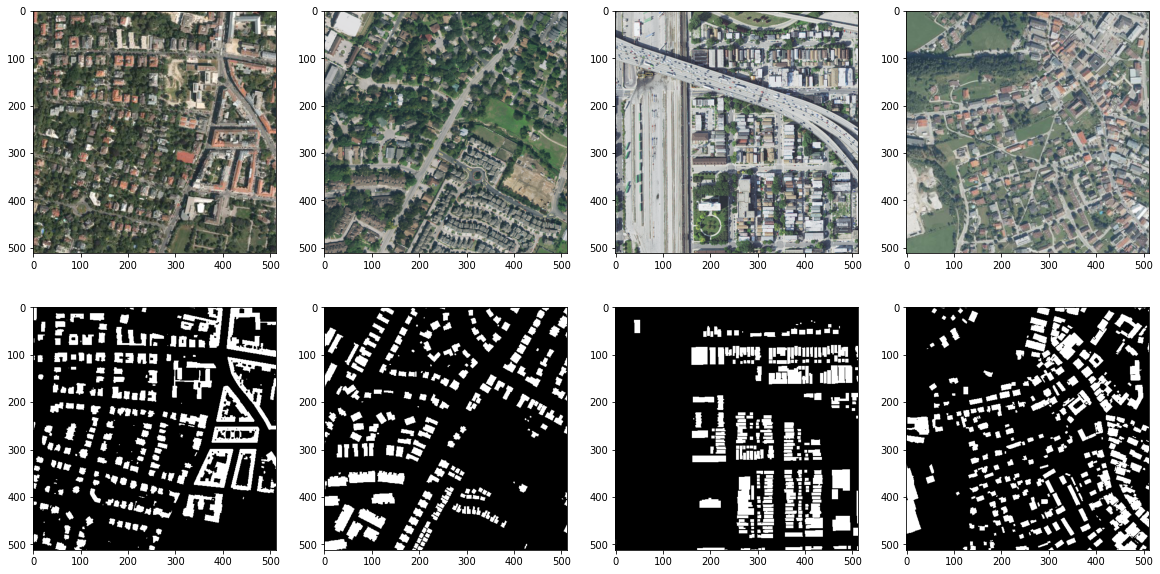

In [6]:
train_example, train_label = next(train_dataset.as_numpy_iterator())
fig, ax = plt.subplots(2,4,figsize=(20,10))
for i in range(4):
    ax[0,i].imshow(train_example[i])
    ax[1,i].imshow(np.reshape(train_label[i],(512,512)),cmap = plt.cm.gray)
plt.show()

### The UNet FCN
We'll program here a "vanilla" UNet based on the architecture described in [de Jong et al. (2019)](https://export.arxiv.org/pdf/1812.05815v2). It consists of a coder and decoder section with lateral connections between the two, which in the literature is usually displayed in the form of a "U". The coder section is a series of 5 pairs of Conv2D convolutional layers, with successively doubling numbers of filters (64, 128, ...), connected by MaxPooling2D layers which successively halve the image dimensions (512, 256, ...). The decoder section reverses the process with the help of upsampling Conv2DTranspose layers, ultimately reconstructing the input image signal at the network output. The input to each upsampling layer conists of the output from the preceding layer, merged (concatenated) with the output of the corresponding Conv2d layer from the coding section. The idea is to restore higher resolution details lost during the image compression (coding) phase while decoding takes place. The model takes as input a three channel RGB image in _np.uint8_ format and outputs an 1-channel image in _np.float32_ format. The output of the last Conv2D layer is passed through a sigmoid activation function.

Since the convolutional layers are all identical except for the number of filters, and since each is followed by a [batch normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) layer, it improves readability to use some shortcut functions. These can be conveniently programmed with the tensorflow _sequential API_:

In [7]:
# shortcuts
def conv2d(filters):
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters,3,padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu')])
def conv2dtranspose(filters):
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2DTranspose(filters,3,strides=2,padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu')])
def maxpooling2d():
    return tf.keras.layers.MaxPooling2D(pool_size=2,strides=2,padding="same")

Here is the full UNet model written in tensorflow's _functional API_:

In [8]:
# UNet
def unet_model(num_channels=3,image_size=512):    
    inputs = tf.keras.layers.Input(shape=(image_size,image_size,num_channels))
    rescaled= tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
#  coder     
    conv11 = conv2d(64)(rescaled)
    conv12 = conv2d(64)(conv11)
    max_pool1 = maxpooling2d()(conv12)
    conv21 = conv2d(128)(max_pool1)
    conv22 = conv2d(128)(conv21)
    max_pool2 = maxpooling2d()(conv22)
    conv31 = conv2d(256)(max_pool2)
    conv32 = conv2d(256)(conv31)
    max_pool3 = maxpooling2d()(conv32)
    conv41 = conv2d(512)(max_pool3)
    conv42 = conv2d(512)(conv41)
    max_pool4 = maxpooling2d()(conv42)
    conv51 = conv2d(1024)(max_pool4)
    conv52 = conv2d(1024)(conv51)
#  decoder    
    uconv51 = conv2dtranspose(512)(conv52)
    merge_dec5 = tf.keras.layers.concatenate([conv42,uconv51],axis=3)
    conv_dec_41 = conv2d(512)(merge_dec5)
    conv_dec_42 = conv2d(512)(conv_dec_41)
    uconv41 = conv2dtranspose(256)(conv_dec_42)
    merge_dec4 = tf.keras.layers.concatenate([conv32,uconv41],axis=3)
    conv_dec_31 = conv2d(256)(merge_dec4)
    conv_dec_32 = conv2d(256)(conv_dec_31)
    uconv31 = conv2dtranspose(128)(conv_dec_32)
    merge_dec3 = tf.keras.layers.concatenate([conv22,uconv31],axis=3)
    conv_dec_21 = conv2d(128)(merge_dec3)
    conv_dec_22 = conv2d(128)(conv_dec_21)
    uconv21 = conv2dtranspose(64)(conv_dec_22)
    merge_dec2 = tf.keras.layers.concatenate([conv12,uconv21],axis=3)
    conv_dec_11 = conv2d(64)(merge_dec2)
    conv_dec_12 = conv2d(64)(conv_dec_11)
#  output    
    conv_dec_12 = conv2d(8)(conv_dec_12)
    output = tf.keras.layers.Conv2D(1,1,activation = 'sigmoid')(conv_dec_12)
    return tf.keras.Model(inputs = inputs, outputs = output)

In [9]:
model = None
model = unet_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 512, 512, 64) 2048        rescaling[0][0]                  
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 512, 512, 64) 37184       sequential[0][0]                 
______________________________________________________________________________________________

We'll also use a standard Adam optimizer with a learning rate of 0.001 and a BinaryCrossentropy loss function corresponding to the sigmoid activation.

In [10]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

This callback reduces the learning rate by 1% after each epoch

In [ ]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):
    old_lr = self.model.optimizer.lr.read_value()
    new_lr = old_lr * 0.99
    print("Epoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
    self.model.optimizer.lr.assign(new_lr)

lrcallback = LearningRateReducerCb()    

### Training
During training it is a good idea to include a callback which saves the model after each epoch whenever the loss has been reduced. The Colab notebook's GPU runtime may be disconnected by the provider at any time during training, particularly when the number of epochs is large (e.g., $\approx 100$) and the model state will otherwise be lost. Since training data are scarce, we will use the test data for both validation and testing.

In [ ]:
callback = ModelCheckpoint(train_folder+'/unet_inria_modelxx.h5', monitor='loss', save_best_only=True)
history = model.fit(train_dataset, epochs=10, callbacks = [callback], validation_data=test_dataset)

Epoch 1/10
 23/152 [===>..........................] - ETA: 8:37 - loss: 0.4581 - binary_accuracy: 0.8246

In [ ]:
model = keras.models.load_model(train_folder+'/unet_inria_modelx.h5')

In [ ]:
model.optimizer.lr.assign(0.0003)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.0003>

### Evaluation
After training for 40 epochs at learn rate 0.001 and 10 epochs at lr of 0.0003:

In [ ]:
model.evaluate(test_dataset)

280/280 [==============================] - 113s 396ms/step - loss: 0.1251 - binary_accuracy: 0.9589


[0.12511524558067322, 0.9589163661003113]

### Intersection over Union (IoU) test

The comparison metric used inthe INRIA benchmark competition was _intersection over union_ (IoU), referring to the sets of labeled and classified pixels. A value of one implies perfect reproduction of the label image, a value zero means no correpondance whatsoever. The cell below calculates the average IoU for the test image/label pairs (recall that they are stored in memory in batches of 4).

In [ ]:
i = 0
sumIoU = 0
for test_example, test_label in test_dataset:
    for j in range(4):
        label = np.reshape(test_label[j],(512,512))
        example = np.reshape(test_example[j],(1,512,512,3))
        pred = model.predict(example)
        pred = np.reshape(np.where(pred>0.5,1,0),(512,512))
        I = label*pred
        U = label+pred-I
        sU = np.sum(U)
        if sU>0: # no buildings in subscene?
            sumIoU += np.sum(I)/sU
            i += 1        
sumIoU/i

0.6722779559931293

This result exceeds to the best results obtained by [Maggiori et al. (2017)](https://hal.inria.fr/hal-01468452/document) in the initial benchmarking of the INRIA dataset using a multi-label perceptron (MLP) architecture (0.60). The [winners](https://hal.inria.fr/hal-01767807/document) of the competition, however, achieved IoUs of the order 0.7 with variations of the UNet model that we are using here. We should remember that all of the competition exercises were performed at 30cm spatial resolution, whereas we are training at 1.2m resolution with a corresonding loss in object discrimination.

### Visual testing

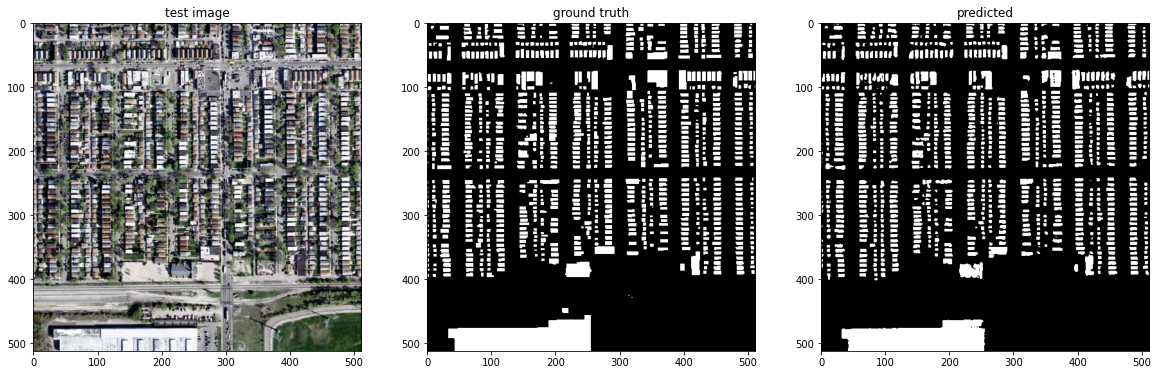

In [ ]:
i = 1
testds = iter(test_dataset)
_, _ = next(testds)
_, _ = next(testds)
test_example, test_label = next(testds)
fig, ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(test_example[i])
label = np.reshape(test_label[i],(512,512))
ax[1].imshow(label,cmap = plt.cm.gray)
pred = model.predict(tf.reshape(test_example[i],(1,512,512,3)))
pred = np.reshape(np.where(pred>0.5,1,0),(512,512))
ax[2].imshow(pred,cmap = plt.cm.gray)
ax[0].set_title('test image')
ax[1].set_title('ground truth')
ax[2].set_title('predicted')
plt.show()